In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
%load_ext autoreload

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from utils import get_best_threshold

In [4]:
%autoreload 2

from utils import (
    prepare_wallets_features_data,
    prepare_wallets_features_data_new,
    get_training_data,
    print_confusion_matrix,
    get_prepared_train_test,
)

In [135]:
wallets_features.columns

Index(['addrId', 'btc_received_total', 'btc_received_min', 'btc_received_max',
       'btc_received_mean', 'incoming_tx_cnt',
       'incoming_tx_input_address_cnt_mean',
       'incoming_tx_output_address_cnt_mean', 'btc_received_gini',
       'input_address_cnt', 'incoming_tx_fees_mean', 'incoming_tx_fees_min',
       'incoming_tx_fees_max', 'incoming_tx_whole_fee_4_cnt', 'btc_sent_total',
       'btc_sent_min', 'btc_sent_max', 'btc_sent_mean', 'outcoming_tx_cnt',
       'outcoming_tx_output_address_cnt_mean',
       'outcoming_tx_input_address_cnt_mean', 'btc_sent_gini',
       'output_address_cnt', 'outcoming_tx_fees_mean', 'outcoming_tx_fees_min',
       'outcoming_tx_fees_max', 'outcoming_tx_whole_fee_4_cnt',
       'outcoming_tx_fees_total', 'outcoming_tx_ts_cnt',
       'outcoming_tx_ts_gini', 'incoming_tx_ts_cnt', 'incoming_tx_ts_gini',
       'Time step', 'class', 'first_block_appeared_in',
       'last_block_appeared_in', 'lifetime_in_blocks', 'userId',
       'user_addr_cnt

In [136]:
wallets_features = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users_agg1.csv")

prep_data = prepare_wallets_features_data_new(wallets_features, type="raw")
X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)


        Best threshold: 0.053526315789473686
        Best F1: 0.6641702127659574, precicion: 0.5244623655913978, recall: 0.9053364269141532
        


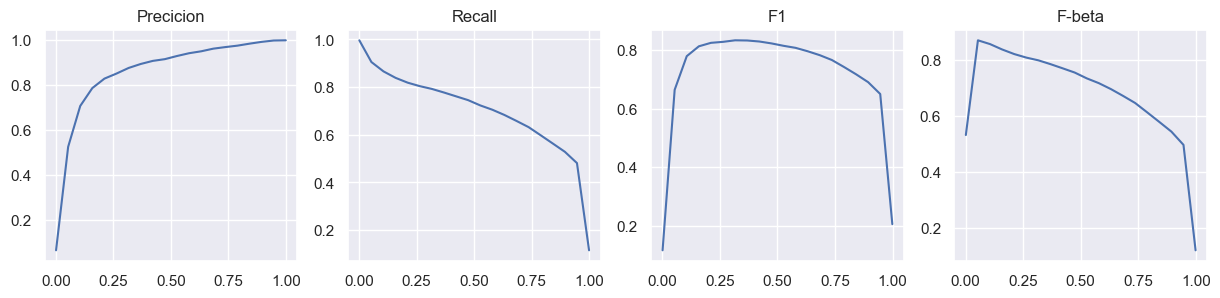

In [137]:
import xgboost as xgb
# prep_data = prepare_wallets_features_data(wallets_features, type="full")
# X_train, X_test, y_train, y_test = get_training_data(prep_data, no_unknown=False)

best_params = {'n_estimators': 297, 'max_depth': 3, 'learning_rate': 0.035945220741013736, 'subsample': 0.7341100732375431, 'colsample_bytree': 0.9953795550039859, 'min_child_weight': 4, 'gamma': 0.3909505373474582, 'reg_alpha': 7.311546429641343, 'reg_lambda': 0.9835545509646224, 'scale_pos_weight': 15.27610123192946}
{'n_estimators': 499, 'max_depth': 12, 'learning_rate': 0.08642767477924684, 'subsample': 0.7546159507404115, 'colsample_bytree': 0.5891330043708496, 'min_child_weight': 4, 'gamma': 1.4141610641516467, 'reg_alpha': 0.7225466198364565, 'reg_lambda': 4.851839884308098, 'scale_pos_weight': 15.498963517602764}
best_params = {}

column_transformer = ColumnTransformer(
    transformers=[
        ('min_max_scale', MinMaxScaler(), list(set(X_train.columns))),
    ]
)

pipeline = Pipeline(steps=[
    ('transformers', column_transformer),
    ('rf', xgb.XGBClassifier(**best_params))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_vals = model.predict(X_test)

res = get_best_threshold(y_pred, y_test, return_hists=True)

In [70]:
from sklearn.metrics import classification_report
thr = 0.28
best_pred_classes = (y_pred >= thr).astype(int)
print_confusion_matrix(y_pred, thr, y_test, with_prec_rec=True)

report_dict = classification_report(y_test, (y_pred >= thr).astype(int), output_dict=True)
pd.DataFrame(report_dict)


	real 1	real 0
pred 1	3462	575	
pred 0	848	241998	
Precicion 0.8575675006192718, Recall 0.8032482598607888, 


,0,1,accuracy,macro avg,weighted avg
precision,0.996508,0.857568,0.994236,0.927038,0.994082
recall,0.997630,0.803248,0.994236,0.900439,0.994236
f1-score,0.997069,0.829520,0.994236,0.913294,0.994143
support,242573.000000,4310.000000,0.994236,246883.000000,246883.000000


In [147]:
from sklearn.metrics import classification_report
thr = 0.28
best_pred_classes = (y_pred >= thr).astype(int)
print_confusion_matrix(y_pred, thr, y_test, with_prec_rec=True)

report_dict = classification_report(y_test, (y_pred >= thr).astype(int), output_dict=True)
pd.DataFrame(report_dict)


	real 1	real 0
pred 1	3447	559	
pred 0	863	242014	
Precicion 0.8604593110334499, Recall 0.7997679814385151, 


,0,1,accuracy,macro avg,weighted avg
precision,0.996447,0.860459,0.99424,0.928453,0.994073
recall,0.997696,0.799768,0.99424,0.898732,0.994240
f1-score,0.997071,0.829004,0.99424,0.913038,0.994137
support,242573.000000,4310.000000,0.99424,246883.000000,246883.000000


## Add users heuristic

In [12]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = get_training_data(wallets_features, no_unknown=False)

In [132]:
addr_to_class = X_test_raw[["addrId", "userId"]]
addr_to_class["predicted_wallet_class"] = best_pred_classes
addr_to_class["real_wallet_classes"] = y_test_raw

addr_to_class = addr_to_class \
    .merge(
        pd.read_csv("../dataset/custom/UserClasses.csv"),
        how="left",
        on="userId",
    ) \
    .rename(columns={"class": "user_class_true"})
addr_to_class["user_class_true"] = (addr_to_class["user_class_true"] == 1).astype(int)

user_classes_all = pd.read_csv("../dataset/custom/UserClasses.csv")
# user_classes_all[user_classes_all["userId"].isin(addr_to_class["userId"])]["class"].value_counts()

user_to_predicted_class = addr_to_class.groupby("userId")["predicted_wallet_class"].max()
user_to_predicted_class = user_to_predicted_class.reset_index().rename(columns={"predicted_wallet_class": "user_class_pred"})

user_to_predicted_class = user_to_predicted_class \
    .merge(
        pd.read_csv("../dataset/custom/UserClasses.csv"),
        how="left",
        on="userId",
    ) \
    .rename(columns={"class": "user_class_true"})
user_to_predicted_class["user_class_true"] = (user_to_predicted_class["user_class_true"] == 1).astype(int)

user_to_addr = pd.read_csv("../dataset/custom/AddrUser.csv")
user_to_addr = user_to_addr.groupby("userId")["addrId"].nunique().reset_index()
user_to_addr = user_to_addr.merge(
        pd.read_csv("../dataset/custom/UserClasses.csv"),
        how="left",
        on="userId",
    )
user_to_addr["class"] = (user_to_addr["class"] == 1).astype(int)
users_with_many_addrs = user_to_addr[(user_to_addr["addrId"] >= 5) & (user_to_addr["addrId"] <= 100)]
users_with_many_addrs.shape

addr_to_class = addr_to_class.merge(
    user_to_predicted_class[["userId", "user_class_pred"]],
    how="left",
    on="userId"
)
addr_to_class


,addrId,userId,predicted_wallet_class,real_wallet_classes,user_class_true,user_class_pred
0,17Y3PmxZHxenhbvEcaCMc4g4jxR4wrTsaa,5913,0,0,0,0
1,1GEtwvCD19t7csVRpQy9qvrvmQpA3CKUTJ,37540,0,0,0,0
2,1KeSiun9PzeyRgqfCmesNPGrZ3YC88XeHc,41058,0,0,0,0
3,1Dj9AenLbrFhyJzMuiSoYsq4FtcT2gdxmX,285810,0,0,0,0
4,1JkTRTzGwekTwhuFG3mw8VYuWv7CxjGd4P,111,0,0,1,0
...,...,...,...,...,...,...
246878,3MFuwpnJ6uHZUqowjuGrLzaKwpucAAhyXp,536253,0,0,0,0
246879,1DuwBrFH8N6Jb4KLovGsZMpRQJxaYM19TH,395028,0,0,0,0
246880,13QrqJkbndFbkS3ZkWv3TNX5kSUnJ3GsXs,4,0,0,1,1
246881,1QAcGbRTtsN2EKVS1BCMYYbDXrGbZgaNXC,283462,0,0,0,0


In [ ]:
addr_to_class["predicted_wallet_class_fixed"] = addr_to_class["predicted_wallet_class"]
users_with_many_addrs_list = set(users_with_many_addrs["userId"].tolist())

def func(row):
    if row["userId"] in users_with_many_addrs_list:
        return row["user_class_pred"]
    return row["predicted_wallet_class"]


addr_to_class["predicted_wallet_class_fixed"] = addr_to_class.apply(
    func, axis=1
)

In [148]:
print_confusion_matrix(
    np.array(addr_to_class["predicted_wallet_class_fixed"]),
    0.1,
    np.array(addr_to_class["real_wallet_classes"]),
)
precision_score(
    np.array(addr_to_class["real_wallet_classes"]),
    np.array(addr_to_class["predicted_wallet_class_fixed"]),
), recall_score(
    np.array(addr_to_class["real_wallet_classes"]),
    np.array(addr_to_class["predicted_wallet_class_fixed"]),
)
report_dict = classification_report(np.array(addr_to_class["real_wallet_classes"]), np.array(addr_to_class["predicted_wallet_class_fixed"]), output_dict=True)
pd.DataFrame(report_dict)


	real 1	real 0
pred 1	3532	905	
pred 0	778	241668	


,0,1,accuracy,macro avg,weighted avg
precision,0.996791,0.796033,0.993183,0.896412,0.993286
recall,0.996269,0.819490,0.993183,0.907879,0.993183
f1-score,0.996530,0.807591,0.993183,0.902061,0.993232
support,242573.000000,4310.000000,0.993183,246883.000000,246883.000000


In [88]:

print_confusion_matrix(
    np.array(addr_to_class["predicted_wallet_class"]),
    0.1,
    np.array(addr_to_class["real_wallet_classes"]),
)
precision_score(
    np.array(addr_to_class["real_wallet_classes"]),
    np.array(addr_to_class["predicted_wallet_class"]),
    
), recall_score(
    np.array(addr_to_class["real_wallet_classes"]),
    np.array(addr_to_class["predicted_wallet_class"]),
)

	real 1	real 0
pred 1	3462	575	
pred 0	848	241998	


(0.8575675006192718, 0.8032482598607888)